In [1]:
from IPython.display import Markdown as md
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#from sklearn.linear_model import LogisticRegression
#from sklearn.metrics import auc as sklearn_auc
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer


In [2]:
import shelve
savefile = 'Savefile.sav'

- Homework source https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/course-zoomcamp/06-trees/homework.md
- Lecture https://github.com/alexeygrigorev/mlbookcamp-code/blob/master/chapter-06-trees/06-trees.ipynb

## 6.10 Homework

The goal of this homework is to create a tree-based regression model for prediction apartment prices (column `'price'`).

In this homework we'll again use the New York City Airbnb Open Data dataset - the same one we used in homework 2 and 3.

You can take it from [Kaggle](https://www.kaggle.com/dgomonov/new-york-city-airbnb-open-data?select=AB_NYC_2019.csv)
or download from [here](https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AB_NYC_2019.csv)
if you don't want to sign up to Kaggle.


For this homework, we prepared a [starter notebook](homework-6-starter.ipynb). 


## Loading the data

* Use only the following columns:
    * `'neighbourhood_group',`
    * `'room_type',`
    * `'latitude',`
    * `'longitude',`
    * `'minimum_nights',`
    * `'number_of_reviews','reviews_per_month',`
    * `'calculated_host_listings_count',`
    * `'availability_365',`
    * `'price'`
* Fill NAs with 0
* Apply the log tranform to `price`
* Do train/validation/test split with 60%/20%/20% distribution. 
* Use the `train_test_split` function and set the `random_state` parameter to 1
* Use `DictVectorizer` to turn the dataframe into matrices

In [3]:
col = ['neighbourhood_group',
    'room_type',
    'latitude',
    'longitude',
    'minimum_nights',
    'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count',
    'availability_365',
    'price']

In [4]:
df = (
 pd.read_csv('../input/new-york-city-airbnb-open-data/AB_NYC_2019.csv')
[col]
.fillna(0)
) 
df['price'] = np.log1p(df['price'])
df.head()

,neighbourhood_group,room_type,latitude,longitude,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,price
0,Brooklyn,Private room,40.64749,-73.97237,1,9,0.21,6,365,5.010635
1,Manhattan,Entire home/apt,40.75362,-73.98377,1,45,0.38,2,355,5.420535
2,Manhattan,Private room,40.80902,-73.94190,3,0,0.00,1,365,5.017280
3,Brooklyn,Entire home/apt,40.68514,-73.95976,1,270,4.64,1,194,4.499810
4,Manhattan,Entire home/apt,40.79851,-73.94399,10,9,0.10,1,0,4.394449


In [5]:
y='price'
test=0.2
val=0.2
seed=1

df_train_full, df_test = train_test_split(df, test_size=test, random_state=seed)
df_train, df_val = train_test_split(df_train_full, test_size=val/(1-test), random_state=seed)

y_test = df_test[y].copy().values
y_val = df_val[y].copy().values
y_train = df_train[y].copy().values
del df_test[y]
del df_val[y]
del df_train[y]

In [6]:
# hot encoding
dict_train = df_train.to_dict(orient='records')
dict_val = df_val.to_dict(orient='records')
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(dict_train)
X_val = dv.transform(dict_val)

## Question 1

Let's train a decision tree regressor to predict the price variable. 

* Train a model with `max_depth=1`


Which feature is used for splitting the data?

* `room_type`
* `neighbourhood_group`
* `number_of_reviews`
* `reviews_per_month`

In [7]:
# https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html
from sklearn.tree import DecisionTreeRegressor

In [8]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [9]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



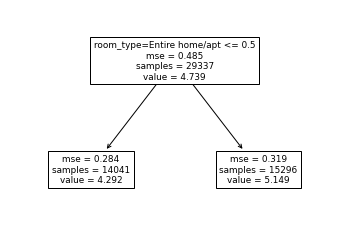

In [10]:
from sklearn.tree import plot_tree
plot_tree(dt, feature_names=dv.get_feature_names())
plt.show()

In [11]:
# first node
feature_id = dt.tree_.feature[0] # [12, -2, -2]
feature_name = dv.get_feature_names()[feature_id] # 'room_type=Entire home/apt'
md(f'### Which feature is used for splitting the data?: **{feature_name.split("=")[0]}**')

### Which feature is used for splitting the data?: **room_type**

## Question 2

Train a random forest model with these parameters:

* `n_estimators=10`
* `random_state=1`
* `n_jobs=-1`  (optional - to make training faster)


What's the RMSE of this model on validation?

* 0.059
* 0.259
* 0.459
* 0.659

In [12]:
# https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html?highlight=randomforest#sklearn.ensemble.RandomForestRegressor
from sklearn.ensemble import RandomForestRegressor
def get_rmse(y_pred, y_true):
    mse = ((y_pred - y_true) ** 2).mean()
    return np.sqrt(mse)
#enddef

In [13]:
rf = RandomForestRegressor(n_estimators=10, random_state=1) # n_jobs=-1
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, random_state=1)

In [14]:
md(f"### What's the RMSE of this model on validation? : **{get_rmse(rf.predict(X_val), y_val):.4f}**")
# 0.4599

### What's the RMSE of this model on validation? : **0.4599**

## Question 3

Now let's experiment with the `n_estimators` parameter

* Try different values of this parameter from 10 to 200 with step 10
* Set `random_state` to `1`
* Evaluate the model on the validation dataset


After which value of `n_estimators` does RMSE stop improving?

- 10
- 50
- 70
- 120

In [15]:
with shelve.open(savefile, 'c') as save: 
    k = 'rmse01'
    if k not in save:
        rmse_list = {}
        for n in np.linspace(10,200,10).astype(int):
            rf = RandomForestRegressor(n_estimators=n, random_state=1,n_jobs=-1) 
            rf.fit(X_train, y_train)
            rmse_list[n] = get_rmse(rf.predict(X_val), y_val)
            print(n,rmse_list[n])
        #endfor
        save[k] = rmse_list
    else:
        rmse_list = save[k]
    #endif
#endwith        

10 0.4598535778342608
31 0.4449740616858785
52 0.4419501068021308
73 0.44090304780000233
94 0.44008336884350485
115 0.43934201468419964
136 0.4391147014994749
157 0.43891067416530244
178 0.4389872111168318
200 0.4389432007046648


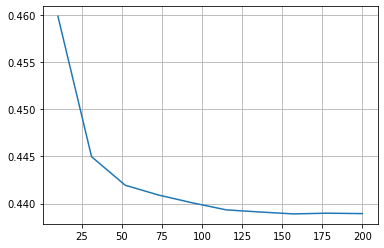

In [16]:
pd.Series(rmse_list).plot()
plt.grid()
plt.show()

### After which value of n_estimators does RMSE stop improving? **120**

## Question 4

Let's select the best `max_depth`:

* Try different values of `max_depth`: `[10, 15, 20, 25]`
* For each of these values, try different values of `n_estimators` from 10 till 200 (with step 10)
* Fix the random seed: `random_state=1`



What's the best `max_depth`:

* 10
* 15
* 20
* 25

In [17]:
rmse_list02 = None
with shelve.open(savefile, 'c') as save: 
    k = 'rmse02'
    if k not in save:
        rmse_list02 = {}
        for d in [10, 15, 20, 25]:
            rmse_list02[d] = rmse_list02.get(d,{}) # create empty Dictionary if key doesn't exist yet
            for n in np.linspace(10,200,10).astype(int):
                if n not in rmse_list02[d]:
                    rf = RandomForestRegressor(n_estimators=n
                                               ,max_depth=d
                                               ,random_state=1
                                              ,n_jobs=-1) # 
                    rf.fit(X_train, y_train)
                    rmse_list02[d][n] = get_rmse(rf.predict(X_val), y_val)
                #endif
                print(d,n,rmse_list02[d][n])
            #endfor
        #endfor
        save[k]= rmse_list02
    else:
        rmse_list02 = save[k]
    #endif
#endwith

10 10 0.445596171749275
10 31 0.4414986504059841
10 52 0.4410130339565325
10 73 0.4407679173594132
10 94 0.440217940598878
10 115 0.4399747638876593
10 136 0.43983174957306237
10 157 0.4396148965840452
10 178 0.4396916099421784
10 200 0.4396792845818297
15 10 0.4498175486561694
15 31 0.43945221581370114
15 52 0.43788522347538045
15 73 0.43742232511680196
15 94 0.4367991021783366
15 115 0.43630885110913603
15 136 0.4362696416747989
15 157 0.43608195053576243
15 178 0.43609089416007457
15 200 0.4361312812227011
20 10 0.4597643861421082
20 31 0.443833611117118
20 52 0.441103667367273
20 73 0.4401594310659682
20 94 0.4391514608761285
20 115 0.4383862781240854
20 136 0.43810293573041603
20 157 0.43773110196271314
20 178 0.4376731213332132
20 200 0.43764564430470415
25 10 0.46070004844483997
25 31 0.44459511621456377
25 52 0.4421442478922863
25 73 0.44131141861554135
25 94 0.4403994906569277
25 115 0.439561299949833
25 136 0.43928048414965926
25 157 0.4390045858586755
25 178 0.43900388848297

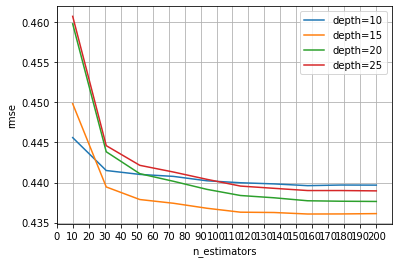

In [18]:
plt.figure(figsize=(6, 4))
for d in [10, 15, 20, 25]:
    x = rmse_list02[d].keys()
    y = [rmse_list02[d][n] for n in x]
    plt.plot(x, y, label=f'depth={d}')
#endfor
plt.xticks(range(0, 201, 10))
plt.grid()
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('rmse')
plt.show()

In [19]:
res = { min([rmse_list02[d][n] for n in rmse_list02[d]]) : d for d in rmse_list02 }
md(f"### What's the best `max_depth`? : **{res[sorted(res)[0]]}**") # 15

### What's the best `max_depth`? : **15**

#### **Bonus question (not graded):**

Will the answer be different if we change the seed for the model?

**Answer**: it should *not*, since n_estimators is sufficently high (>100).

## Question 5

We can extract feature importance information from tree-based models. 

At each step of the decision tree learning algorith, it finds the best split. 
When doint it, we can calculate "gain" - the reduction in impurity before and after the split. 
This gain is quite useful in understanding what are the imporatant features 
for tree-based models.

In Scikit-Learn, tree-based models contain this information in the
[`feature_importances_`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor.feature_importances_)
field. 

For this homework question, we'll find the most important feature:

* Train the model with these parametes:
    * `n_estimators=10`,
    * `max_depth=20`,
    * `random_state=1`,
    * `n_jobs=-1` (optional)
* Get the feature importance information from this model


What's the most important feature? 

* `neighbourhood_group=Manhattan`
* `room_type=Entire home/apt`	
* `longitude`
* `latitude`

In [20]:
rf = RandomForestRegressor(n_estimators=10
                           ,max_depth=20
                           ,random_state=1
                          ,n_jobs=-1) # 
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=20, n_estimators=10, n_jobs=-1, random_state=1)

In [21]:
importances = list(zip(dv.feature_names_, rf.feature_importances_))
df_importance = (
    pd.DataFrame(importances, columns=['feature', 'gain'])
#       [lambda x : x['gain'] > 0]
     .sort_values(by='gain', ascending=False)
)
md(f"### What's the most important feature? : **{df_importance['feature'].iloc[0]}**")
# room_type=Entire home/apt

### What's the most important feature? : **room_type=Entire home/apt**

## Question 6

Now let's train an XGBoost model! For this question, we'll tune the `eta` parameter

* Install XGBoost
* Create DMatrix for train and validation
* Create a watchlist
* Train a model with these parameters for 100 rounds:

```
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
```

Now change `eta` first to `0.1` and then to `0.01`

What's the best eta?

* 0.3
* 0.1
* 0.01

In [22]:
import xgboost as xgb # Install XGBoost
def parse_xgb_output(output):
    tree = []
    p_train = []
    p_val = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        tree.append(it)
        p_train.append(train)
        p_val.append(val)

    return tree, p_train, p_val
#enddef

In [23]:
# Create DMatrix for train and validation
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=dv.feature_names_)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=dv.feature_names_)
# Create a watchlist
watchlist = [(dtrain, 'train'), (dval, 'val')]
# Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,

    'objective': 'reg:squarederror',
    'nthread': 8,

    'seed': 1,
    'verbosity': 1,
}

In [24]:
%%capture output
# capture instruction that saves the result to output 
xgb_params['eta'] = 0.3
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

Eta=0.3 : Best performance (squarederror, number of trees)  (0.43384, 50)


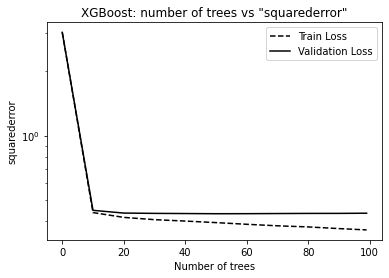

In [25]:
tree, p_train, p_val = parse_xgb_output(output)
print(f'Eta={xgb_params["eta"]} : Best performance (squarederror, number of trees) ', min(zip(p_val, tree)))

plt.figure(figsize=(6, 4))
plt.plot(tree, p_train, color='black', linestyle='dashed', label='Train Loss')
plt.plot(tree, p_val, color='black', linestyle='solid', label='Validation Loss')
# plt.xticks(range(0, 101, 25))
plt.legend()
plt.title('XGBoost: number of trees vs "squarederror"')
plt.xlabel('Number of trees')
plt.ylabel('squarederror')
plt.yscale('log')
plt.show()

In [26]:
%%capture output_010
# capture instruction that saves the result to output 
xgb_params['eta'] = 0.1
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [27]:
tree, _, p_val = parse_xgb_output(output_010)
print(f'Eta={xgb_params["eta"]} : Best performance (squarederror, number of trees) ', min(zip(p_val, tree)))

Eta=0.1 : Best performance (squarederror, number of trees)  (0.4325, 99)


In [28]:
%%capture output_001
# capture instruction that saves the result to output 
xgb_params['eta'] = 0.01
model = xgb.train(xgb_params, dtrain,
                  num_boost_round=100,
                  evals=watchlist, verbose_eval=10)

In [29]:
tree, _, p_val = parse_xgb_output(output_001)
print(f'Eta={xgb_params["eta"]} : Best performance (squarederror, number of trees) ', min(zip(p_val, tree)))

Eta=0.01 : Best performance (squarederror, number of trees)  (1.63045, 99)


Eta=0.3 : Best performance (squarederror, number of trees)  (0.43384, 50)
Eta=0.1 : Best performance (squarederror, number of trees)  (0.4325, 99)
Eta=0.01 : Best performance (squarederror, number of trees)  (1.63045, 99)


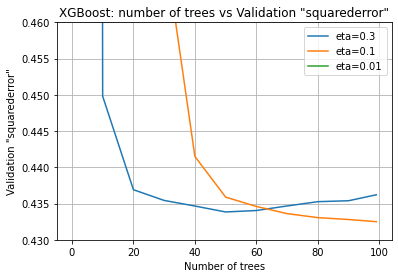

In [30]:
plt.figure(figsize=(6, 4))
for eta, out in zip([0.3,0.1,0.01],[output,output_010,output_001]):
    tree, _, p_val = parse_xgb_output(out)
    #plt.plot(tree, p_train, color='black', linestyle='dashed', label='eta=eta, Train Loss')
    plt.plot(tree, p_val, linestyle='solid', label=f'eta={eta}')
    print(f'Eta={eta} : Best performance (squarederror, number of trees) ', min(zip(p_val, tree)))
    
# plt.xticks(range(0, 101, 25))
plt.legend()
plt.title('XGBoost: number of trees vs Validation "squarederror"')
plt.xlabel('Number of trees')
plt.ylabel('Validation "squarederror"')
# plt.yscale('log')
plt.ylim(0.43,0.46)
plt.grid()
plt.show()

In [31]:
md("### What's the best eta? **0.1**")

### What's the best eta? **0.1**